# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
# --- Extension Setup ---
%load_ext autoreload
%load_ext line_profiler
%autoreload 2 -p

# --- Module Imports ---
import sys
sys.path.append("..")  # Adjust if your afml repo is nested differently

# --- Autoreload Target ---
%aimport afml

# --- AFML Initialization ---
import afml

# --- Logging (Optional but Recommended) ---
from loguru import logger
from pathlib import Path

# Optional: clear old logs
log_path = Path("logs") / "afml_session.log"
log_path.parent.mkdir(exist_ok=True)
log_path.unlink(missing_ok=True)

# Configure Loguru
logger.add(log_path, level="INFO", rotation="10 MB", retention="10 days")
logger.info("Session started")

# --- Environment Diagnostics ---
from pathlib import Path
import platform
print(f"Platform: {platform.system()} {platform.release()}")
print(f"Working Dir: {Path.cwd()}")


2025-09-03 02:15:30.961 | DEBUG    | afml.cache:_configure_numba:61 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-03 02:15:30.962 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-09-03 02:15:30.962 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-09-03 02:15:30.964 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-03 02:15:35.378 | DEBUG    | afml.cache.selective_cleaner:_load_tracking_data:39 - Loaded tracking data for 14 functions


2025-09-03 02:15:39.438 | INFO     | afml:<module>:365 - AFML v1.0.0 ready - 10 heavy modules available for lazy loading
2025-09-03 02:15:39.452 | INFO     | __main__:<module>:27 - Session started
Platform: Windows 10
Working Dir: c:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\notebooks


In [2]:
import warnings
import winsound
from datetime import datetime as dt
from datetime import timedelta
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.ensemble import RandomForestClassifier

from afml.backtest_statistics.reporting import (
    compare_roc_curves,
    meta_labelling_classification_reports,
    meta_labelling_reports,
)
from afml.cache import clear_afml_cache
from afml.data_structures.bars import *
from afml.features import get_fractal_features, get_time_features, is_stationary
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    calculate_label_metrics,
    get_bins_from_trend,
    get_event_weights,
    get_trend_scanning_meta_labels,
    triple_barrier_labels,
)
from afml.mt5.load_data import (
    clean_tick_data,
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
)
from afml.strategies import (
    BollingerMeanReversionStrategy,
    MovingAverageCrossoverStrategy,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    CLEAN_DATA_PATH,
    COMMODITIES,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    GREEKS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    get_period_vol,
    smart_subscript,
    to_subscript,
    value_counts_data,
)
from notebooks.training import train_meta_model

warnings.filterwarnings("ignore")
plt.style.use("dark_background")
warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [3]:
# clear_afml_cache()

In [4]:
from afml.cache.selective_cleaner import *

pprint(cache_maintenance(), sort_dicts=False)

2025-09-03 02:15:43.393 | INFO     | afml.cache.selective_cleaner:selective_cache_clear:274 - No function changes detected
2025-09-03 02:15:43.697 | INFO     | afml.cache.selective_cleaner:cache_maintenance:425 - Cache maintenance completed: 13 functions checked
{'functions_checked': 13,
 'changed_functions': [],
 'cleared_functions': [],
 'size_cleared_mb': 0,
 'old_files_removed': 0}


## 1. Data Preparation

In [5]:
account = "FundedNext_STLR2_6K"
# account = "METAQUOTES_DEMO_25K"
# account = login_mt5(account)
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date

In [6]:
def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict.get(timeframe)
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
            print(f"Loading ticks from {CLEAN_DATA_PATH}...")
        except FileNotFoundError:
            print(f"Downloading ticks to {DATA_PATH}...")
            save_data_to_parquet(DATA_PATH, symbol, start_date, end_date, account)
            tick_df = load_tick_data(DATA_PATH, symbol, start_date, end_date, account, columns)
            tick_df = clean_tick_data(tick_df)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [7]:
# import MetaTrader5 as mt5
# from afml.util.misc import date_conversion

# timeframe = "H4"
# start_date_, end_date_ = date_conversion("2009", end_date)
# mt5_timeframe = getattr(mt5, f"TIMEFRAME_{timeframe}")
# df = pd.DataFrame(mt5.copy_rates_range(symbol, mt5_timeframe, start_date_, end_date_))
# if df is not None:
#     df["time"] =  pd.to_datetime(df["time"], unit="s", utc=True)
#     df.set_index("time", inplace=True)
#     fname = Path("../data", f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
#     df = optimize_dtypes(df)
#     df.to_parquet(fname)
#     df.info()
        

In [8]:
bb_timeframe = "M5"
tick_bar_size = tick_bar_dict.get(bb_timeframe)
print(f"{bb_timeframe} = tick-{tick_bar_size}")
bb_time_bars, bb_tick_bars = get_data(symbol, bb_timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"

bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerMeanReversionStrategy(window=bb_period, num_std=bb_std)
bb_lookback = 10
bb_pt_barrier, bb_sl_barrier, bb_time_horizon = (2, 1, 20)
bb_vol_multiplier = 1

M5 = tick-200
Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [9]:
bb_df = bb_time_bars.loc[sample_start : sample_end]
close = bb_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * bb_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
bb_side = bb_strategy.generate_signals(bb_df)
vertical_barriers = add_vertical_barrier(t_events, close, num_bars=bb_time_horizon)
time_decay = 0.3
linear_decay = False

CUSUM filter threshold: 0.1425%, t_events: 9,708


#### Feature Engineering

In [10]:

# No shifting b/c mean-reversion seems to benefit from contemporaneous information
bb_feat = create_bollinger_features(bb_df, bb_lookback, bb_period, bb_std)

trend_feat = get_bins_from_trend(bb_df.close, span=(5, bb_period), volatility_threshold=0.3, lookforward=False)
trend_cols = ['window', 't_value', 'rsquared']
bb_feat = bb_feat.join(trend_feat[trend_cols]).rename(columns={k: f"trend_{k}" for k in trend_cols})
bb_feat = optimize_dtypes(bb_feat)
bb_feat.info()

bb_feat_time = bb_feat.copy()
not_stationary = is_stationary(bb_feat_time.dropna())

2025-09-03 02:15:53.249 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
Memory usage reduced from 72.35 MB to 68.97 MB (4.7% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295657 entries, 2018-01-01 23:05:00 to 2021-12-31 23:00:00
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        295657 non-null  float32
 1   bb_bandwidth      295638 non-null  float32
 2   bb_percentage     295638 non-null  float64
 3   returns           295656 non-null  float32
 4   returns_5         295652 non-null  float32
 5   returns_10     

#### Fixed-Time Horizon Method

In [11]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
bb_events_fh_time = bb_events_fh.copy()
bb_events_fh.info()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()

av_uniqueness = bb_events_fh['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")
print(f"Sharpe Ratio: {sr_bb_fh:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9699 entries, 2018-01-03 02:45:00 to 2021-12-31 17:30:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      9699 non-null   datetime64[ns]
 1   ret     9699 non-null   float64       
 2   trgt    9699 non-null   float64       
 3   bin     9699 non-null   int8          
 4   side    9699 non-null   int8          
 5   tW      9699 non-null   float64       
 6   w       9699 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int8(2)
memory usage: 731.6 KB

Average Uniqueness: 0.7026
Sharpe Ratio: 0.0426


#### Triple-Barrier Method

In [12]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_time = bb_events_tbl.copy()
bb_events_tbl.info()

ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
av_uniqueness = bb_events_tbl['tW'].mean()
print(f"\nAverage Uniqueness: {av_uniqueness:.4f}")
print(f"Sharpe Ratio: {sr_bb_tbl:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9699 entries, 2018-01-03 02:45:00 to 2021-12-31 17:30:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      9699 non-null   datetime64[ns]
 1   ret     9699 non-null   float64       
 2   trgt    9699 non-null   float64       
 3   bin     9699 non-null   int8          
 4   side    9699 non-null   int8          
 5   tW      9699 non-null   float64       
 6   w       9699 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int8(2)
memory usage: 731.6 KB

Average Uniqueness: 0.7605
Sharpe Ratio: 0.0309


In [13]:
print(f"Bollinger_w{bb_period}_std{bb_std}: \n")

bb_metrics_df = pd.Series({
    "fixed_horizon": sr_bb_fh,
    "triple_barrier": sr_bb_tbl,
    }, name="sharpe_ratio").round(4)
print(f"\n{bb_metrics_df}")

Bollinger_w20_std1.5: 


fixed_horizon     0.0426
triple_barrier    0.0309
Name: sharpe_ratio, dtype: float64


#### Trend-Scanning Method

In [14]:
span = (5, 20)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean() * bb_vol_multiplier
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close

bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_time = bb_events_trend.copy()
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()


bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_mr_time = bb_events_trend_mr.copy()
# bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)
ret = bb_events_trend_mr.ret
sr_bb_trend_mr = ret.mean() / ret.std()

print(f"Bollinger_w{bb_period}_std{bb_std}:")
print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}")
bb_metrics_df = pd.Series({
    "fixed_horizon": sr_bb_fh,
    "triple_barrier": sr_bb_tbl,
    "trend_scanning": sr_bb_trend,
    "trend_scanning_mr": sr_bb_trend_mr,
    }, 
    name="sharpe_ratio",
    ).round(4)
print(f"\n{bb_metrics_df}")

Bollinger_w20_std1.5:
bb_events_trend.shape: (9708, 8), bb_events_trend_mr.shape: (9708, 8)

fixed_horizon        0.0426
triple_barrier       0.0309
trend_scanning       0.0504
trend_scanning_mr    0.0381
Name: sharpe_ratio, dtype: float64


### Tick-Bars

In [15]:
bb_df = bb_tick_bars.loc[sample_start : sample_end]
close = bb_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * bb_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
bb_side = bb_strategy.generate_signals(bb_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(bb_timeframe) if x.isnumeric()))
bb_tick_horizon = bb_time_horizon * tm
if bb_timeframe.startswith("H"):
    bb_tick_horizon *= 60
elif bb_timeframe.startswith("D"):
    bb_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=bb_tick_horizon)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=bb_tick_horizon)

CUSUM filter threshold: 0.1263%, t_events: 14,777
Time Horizon: 0 days 01:40:00


#### Feature Engineering

In [16]:
# No shifting b/c mean-reversion seems to benefit from contemporaneous information
lookback = 10
bb_feat = create_bollinger_features(bb_df, bb_lookback, bb_period, bb_std)

trend_feat = get_bins_from_trend(bb_df.close, span=(5, bb_period), volatility_threshold=0.3, lookforward=False)
trend_cols = ['window', 't_value', 'rsquared']
bb_feat = bb_feat.join(trend_feat[trend_cols]).rename(columns={k: f"trend_{k}" for k in trend_cols})
bb_feat = optimize_dtypes(bb_feat)
bb_feat.info()
bb_feat_tick = bb_feat.copy()

2025-09-03 02:16:44.686 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
Memory usage reduced from 109.06 MB to 104.17 MB (4.5% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 427432 entries, 2018-01-01 23:53:43.270001 to 2021-12-31 22:54:42.047001
Data columns (total 51 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        427432 non-null  float32
 1   bb_bandwidth      427413 non-null  float32
 2   bb_percentage     427413 non-null  float64
 3   returns           427431 non-null  float32
 4   returns_5         427427 non-null  float32
 5  

#### Fixed-Time Horizon Method

In [17]:
bb_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_fh = get_event_weights(bb_events_fh, close)
bb_events_fh.info()
bb_events_fh_tick = bb_events_fh.copy()

ret = bb_events_fh.ret
sr_bb_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_bb_fh:.4f}")

Reloading 'afml'.
2025-09-03 02:16:57.960 | INFO     | afml.cache:initialize_cache_system:310 - AFML cache system initialized:
2025-09-03 02:16:57.961 | INFO     | afml.cache:initialize_cache_system:311 -   Joblib cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-09-03 02:16:57.963 | INFO     | afml.cache:initialize_cache_system:312 -   Numba cache: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-09-03 02:16:57.965 | INFO     | afml.cache:initialize_cache_system:318 -   Loaded stats: 5 functions, 0.0% hit rate
2025-09-03 02:16:57.967 | INFO     | afml:<module>:365 - AFML v1.0.0 ready - 10 heavy modules available for lazy loading
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14766 entries, 2018-01-03 01:33:54.426001 to 2021-12-31 18:24:32.629001
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      14766 non-null  datetime64[ns]
 1   ret     14766 non-null  float64      

#### Triple-Barrier Method

In [18]:
bb_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[bb_pt_barrier, bb_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=bb_side,
    vertical_barrier_zero=True,
    verbose=False,
)
bb_events_tbl = get_event_weights(bb_events_tbl, close)
bb_events_tbl_tick = bb_events_tbl.copy()
bb_events_tbl.info()

ret = bb_events_tbl.ret
sr_bb_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_bb_tbl:.4f}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14766 entries, 2018-01-03 01:33:54.426001 to 2021-12-31 18:24:32.629001
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t1      14766 non-null  datetime64[ns]
 1   ret     14766 non-null  float64       
 2   trgt    14766 non-null  float64       
 3   bin     14766 non-null  int8          
 4   side    14766 non-null  int8          
 5   tW      14766 non-null  float64       
 6   w       14766 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int8(2)
memory usage: 1.2 MB

Sharpe Ratio: 0.0205


In [19]:
print(f"Bollinger_w{bb_period}_std{bb_std}:")

bb_metrics_df = pd.Series({
    "fixed_horizon": sr_bb_fh,
    "triple_barrier": sr_bb_tbl,
    }, name="sharpe_ratio").round(4)

print(f"\n{bb_metrics_df}")

Bollinger_w20_std1.5:

fixed_horizon     0.0294
triple_barrier    0.0205
Name: sharpe_ratio, dtype: float64


#### Trend-Scanning Method

In [20]:
from afml.filters.filters import cusum_filter
from afml.labeling.trend_scanning import get_trend_scanning_meta_labels
from afml.util.volatility import get_daily_vol

span = (5, 20)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean() * bb_vol_multiplier
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close

bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_tick = bb_events_trend.copy()
ret = bb_events_trend.ret
sr_bb_trend = ret.mean() / ret.std()


bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_mr_tick = bb_events_trend_mr.copy()
# bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)
ret = bb_events_trend_mr.ret
sr_bb_trend_mr = ret.mean() / ret.std()

print(f"Bollinger_w{bb_period}_std{bb_std}:")
print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}")

bb_metrics_df = pd.Series({
    "fixed_horizon": sr_bb_fh,
    "triple_barrier": sr_bb_tbl,
    "trend_scanning": sr_bb_trend,
    "trend_scanning_mr": sr_bb_trend_mr,
    }, name="sharpe_ratio").round(4)
print(f"\n{bb_metrics_df}")

Bollinger_w20_std1.5:
bb_events_trend.shape: (14777, 8), bb_events_trend_mr.shape: (14777, 8)

fixed_horizon        0.0294
triple_barrier       0.0205
trend_scanning       0.0383
trend_scanning_mr    0.0280
Name: sharpe_ratio, dtype: float64


### Random Forest

In [21]:
random_state = 52
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )
dashes = "-" * 60
time_decay = 0.3

##### Time-Bars

In [22]:
model_bb_fh_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_time, plot_roc=False)

2025-09-03 02:17:20.061 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:17:20.120 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.31    

In [23]:
model_bb_tbl_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_time, plot_roc=False)

2025-09-03 02:17:38.769 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:17:38.837 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.69      0.

In [24]:
model_bb_trend_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_time, plot_roc=False)

2025-09-03 02:18:04.507 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:18:04.573 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.

In [25]:
model_bb_trend_mr_time = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_time, plot_roc=False)

2025-09-03 02:18:26.389 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:18:26.579 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0

###### Return-Weighted

In [26]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, sample_weights=True)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_time_w, plot_roc=False)

2025-09-03 02:18:49.807 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1640
           1       0.00      0.00      0.00      1269

    accuracy                        

In [27]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, sample_weights=True)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_time_w, plot_roc=False)

2025-09-03 02:19:12.514 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      2736
           1       0.09      0.74      0.16       173

    accuracy                           0

In [28]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_time_w, plot_roc=False)

2025-09-03 02:19:35.674 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:19:35.743 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.3

In [29]:
model_bb_trend_mr_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_time_w, plot_roc=False)

2025-09-03 02:19:55.505 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:19:55.643 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.

###### Time-Decay Weighted

In [30]:
time_decays = (0.3, 0.5, 0.7, 1)

In [31]:
models_bb_time_tw = {
    decay: {
    "fixed_horizon": None, 
    "triple_barrier": None, 
    f"trend_scanning_{volatility_threshold}": None, 
    f"trend_scanning_{volatility_threshold_mr}": None,
    } for decay in time_decays
    }

In [32]:
for time_decay in time_decays:
    model_bb_fh_time_tw = train_meta_model(
        model=rf, features=bb_feat_time, labels=bb_events_fh_time, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_time_tw[time_decay]["fixed_horizon"] = model_bb_fh_time_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_fh_time_tw, plot_roc=False)

2025-09-03 02:20:09.993 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.3

2025-09-03 02:20:38.271 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.5

2025-09-03 02:21:02.799 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.7

2025-09-03 02:21:24.552 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 1



In [33]:
for time_decay in time_decays:
    model_bb_tbl_time_tw = train_meta_model(
        model=rf, features=bb_feat_time, labels=bb_events_tbl_time, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_time_tw[time_decay]["triple_barrier"] = model_bb_tbl_time_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_tbl_time_tw, plot_roc=False)

Reloading 'afml.strategies.bollinger_features'.
2025-09-03 02:21:43.614 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.3

2025-09-03 02:22:05.709 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.5

2025-09-03 02:22:25.439 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 0.7

2025-09-03 02:22:47.405 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Training done for decay = 1



In [34]:
for time_decay in time_decays:
    model_bb_trend_time_tw = train_meta_model(
        model=rf, features=bb_feat_time, labels=bb_events_trend_time, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_time_tw[time_decay][f"trend_scanning_{volatility_threshold}"] = model_bb_trend_time_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_trend_time_tw, plot_roc=False)

2025-09-03 02:23:10.737 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:23:12.419 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.3

2025-09-03 02:23:33.633 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:23:35.542 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.5

2025-09-03 02:23:58.722 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:23:59.797 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.7

2025-09-03 02:24:18.784 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:24:19.587 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 1



In [35]:
for time_decay in time_decays:
    model_bb_trend_mr_time_tw = train_meta_model(
        model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_time_tw[time_decay][f"trend_scanning_{volatility_threshold_mr}"] = model_bb_trend_mr_time_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_trend_mr_time_tw, plot_roc=False)

2025-09-03 02:24:39.456 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:24:40.346 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.3

2025-09-03 02:24:52.240 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:24:54.326 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.5

2025-09-03 02:25:08.346 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:25:09.327 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 0.7

2025-09-03 02:25:22.678 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:25:24.571 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Training done for decay = 1



###### Reports

In [36]:
dirpath = Path("reports", "time_bars", bb_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

plot_titles = [
    f"Fixed-Time Horizon (h={bb_time_horizon})", 
    f"Triple-Barrier (pt={bb_pt_barrier}, sl={bb_sl_barrier}, h={bb_time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
bb_titles = [
    "Fixed-Time Horizon", 
    "Triple-Barrier",
    f"Trend-Scanning (σ = {volatility_threshold})",
    f"Trend-Scanning (σ = {volatility_threshold_mr})"
    ]

name = bb_strategy.get_strategy_name().replace("Bollinger", "bb")
filenames = [
    f"{name}_fixed_horizon",
    f"{name}_triple_barrier",
    f"{name}_trend_scanning_{volatility_threshold}",
    f"{name}_trend_scanning_{volatility_threshold_mr}"
    ]

2025-09-03 02:25:40.908 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\unweighted\bb_w20_std1.5_fixed_horizon_primary_clf_report.png'
2025-09-03 02:25:40.973 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\unweighted\bb_w20_std1.5_fixed_horizon_meta_clf_report.png'
2025-09-03 02:25:41.034 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\unweighted\bb_w20_std1.5_triple_barrier_primary_clf_report.png'
2025-09-03 02:25:41.092 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\unweighted\bb_w20_std1.5_triple_barrier_meta_clf_report.png'
2025-09-03 02:25:41.151 | INFO     | afml.backtest_statistics.reporting:create_c

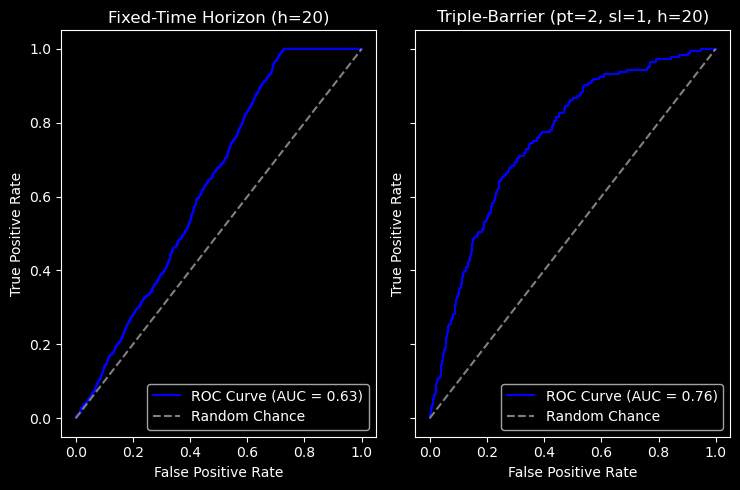

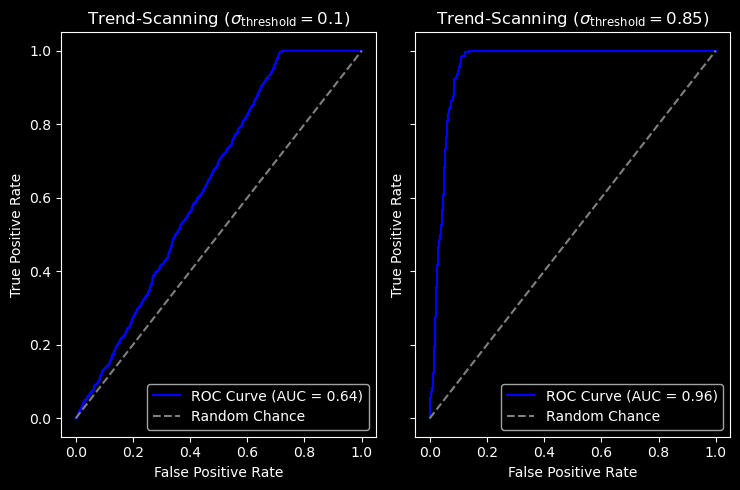

In [37]:
fp = Path(dirpath, "unweighted")

bb_models = [model_bb_fh_time, model_bb_tbl_time, model_bb_trend_time, model_bb_trend_mr_time]

bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png")

bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

2025-09-03 02:25:44.440 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_fixed_horizon_w_primary_clf_report.png'
2025-09-03 02:25:44.505 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_fixed_horizon_w_meta_clf_report.png'
2025-09-03 02:25:44.574 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_triple_barrier_w_primary_clf_report.png'
2025-09-03 02:25:44.633 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\return_weighted\bb_w20_std1.5_triple_barrier_w_meta_clf_report.png'
2025-09-03 02:25:44.695 | INFO     | afml.backtest_s

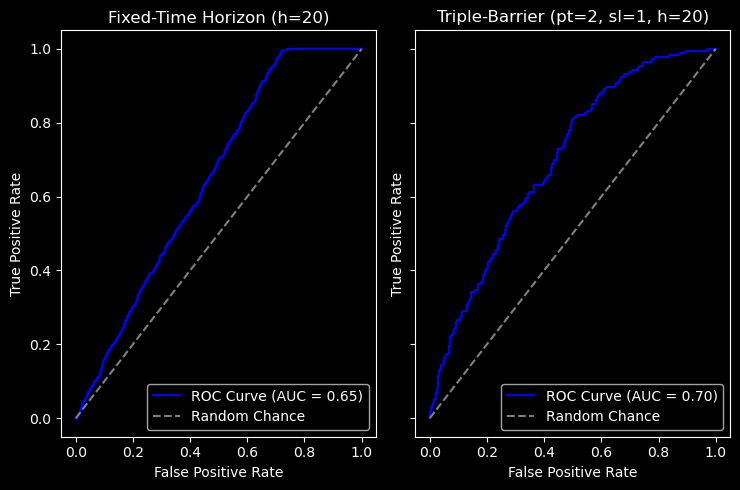

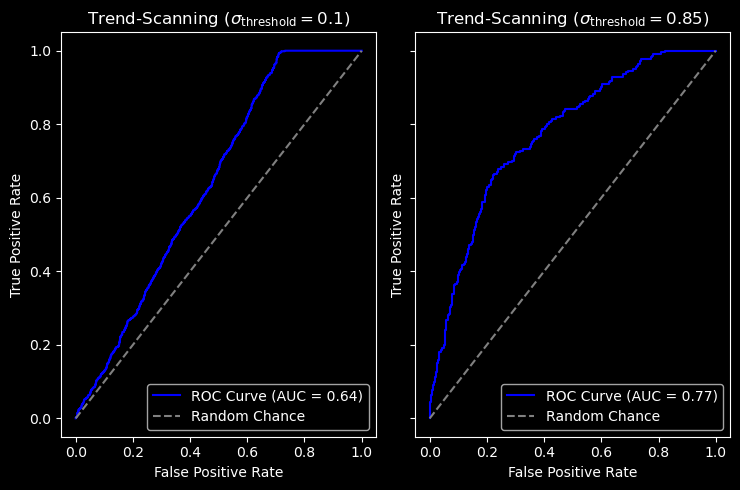

In [38]:
fp_w = Path(dirpath, "return_weighted") 

bb_models_w = [model_bb_fh_time_w, model_bb_tbl_time_w, model_bb_trend_time_w, model_bb_trend_mr_time_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

bb_roc_w = compare_roc_curves(bb_models_w[:2], plot_titles[:2], columns=2)
bb_roc_w.savefig(dirpath / "bb_roc_barrier_comparison_w.png")

bb_roc_trend_w = compare_roc_curves(bb_models_w[2:], plot_titles[2:], columns=2)
bb_roc_trend_w.savefig(dirpath / "bb_roc_trend_comparison_w.png")

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [39]:
fp_tw = Path(dirpath, "time_weighted") 
plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
columns = 2
height = 7.5
fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
for time_decay, labels in models_bb_time_tw.items():
    for i, (label, model) in enumerate(labels.items()):
        bb_models_tw.append(model)
        bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
        filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

meta_labelling_classification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)


2025-09-03 02:25:46.459 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\time_weighted\bb_w20_std1.5_fixed_horizon_tw_0.3_primary_clf_report.png'
2025-09-03 02:25:46.534 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\time_weighted\bb_w20_std1.5_fixed_horizon_tw_0.3_meta_clf_report.png'
2025-09-03 02:25:46.609 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\time_weighted\bb_w20_std1.5_triple_barrier_tw_0.3_primary_clf_report.png'
2025-09-03 02:25:46.682 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\time_bars\M5\time_weighted\bb_w20_std1.5_triple_barrier_tw_0.3_meta_clf_report.png'
2025-09-03 02:25:46.764 | INFO     | afm

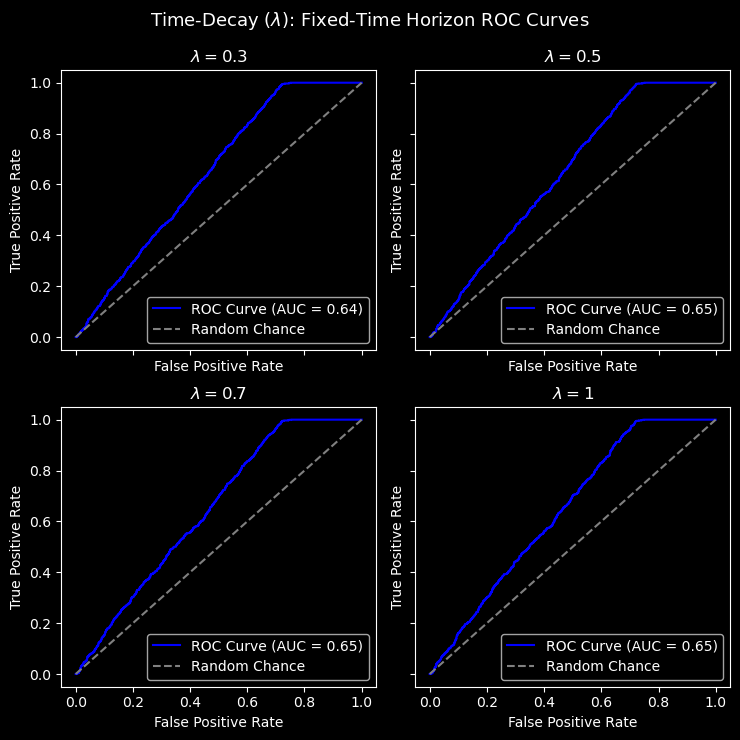

In [40]:
fig_title = fig_titles[0]
bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png")


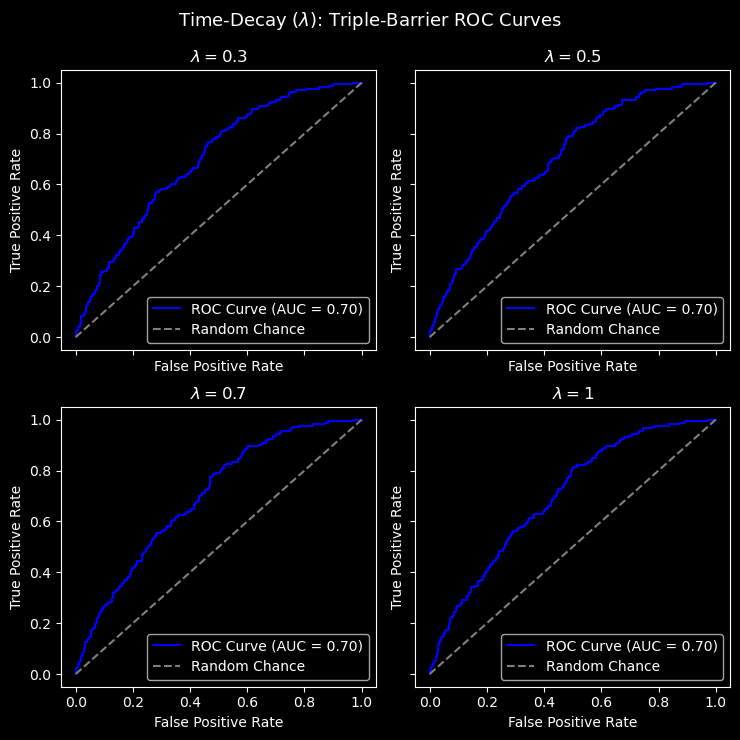

In [41]:
fig_title = fig_titles[1]
bb_roc_tbl_tw = compare_roc_curves(bb_models_tw[1::4], plot_titles_tw, fig_title, columns, height)
bb_roc_tbl_tw.savefig(dirpath / "bb_roc_barrier_comparison_time_weighted.png")

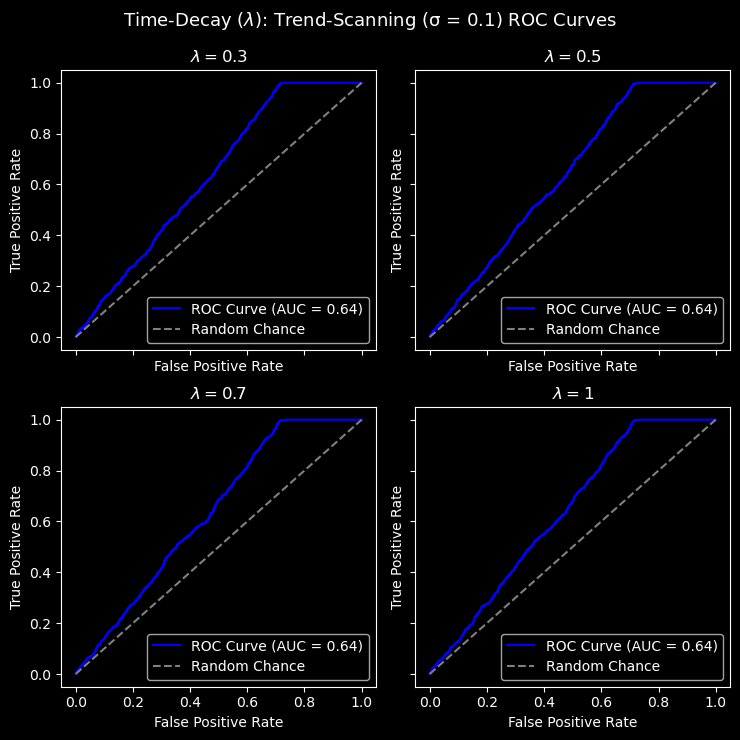

In [42]:
fig_title = fig_titles[2]
bb_roc_trend_tw = compare_roc_curves(bb_models_tw[2::4], plot_titles_tw, fig_title, columns, height)
bb_roc_trend_tw.savefig(dirpath / f"bb_roc_trend_{volatility_threshold}_comparison_time_weighted.png")


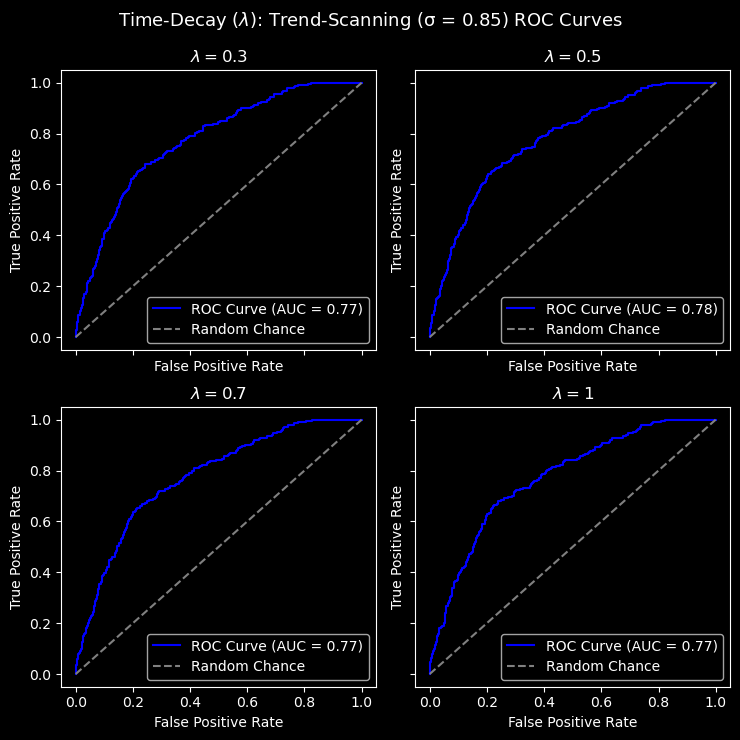

In [43]:
fig_title = fig_titles[3]
bb_roc_trend_mr_tw = compare_roc_curves(bb_models_tw[3::4], plot_titles_tw, fig_title, columns, height)
bb_roc_trend_mr_tw.savefig(dirpath / f"bb_roc_trend_{volatility_threshold_mr}_comparison_time_weighted.png")

##### Tick-Bars

In [44]:
model_bb_fh_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_tick, plot_roc=False)

2025-09-03 02:26:03.325 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:26:03.454 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2370
           1       0.46      1.00      0.63      2059

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.22      0.46      0.30      4429


Confusion Matrix:
[[   0 2370]
 [   0 2059]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.30   

In [45]:
model_bb_tbl_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_tick, plot_roc=False)

Reloading 'afml.sample_weights.optimized_attribution'.
2025-09-03 02:26:37.591 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:26:37.889 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4107
           1       0.07      1.00      0.14       322

    accuracy                           0.07      4429
   macro avg       0.04      0.50      0.07      4429
weighted avg       0.01      0.07      0.01      4429


Confusion Matrix:
[[   0 4107]
 [   0  322]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-sc

In [46]:
model_bb_trend_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_tick, plot_roc=False)

Reloading 'afml.sampling.concurrent'.
2025-09-03 02:27:18.654 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:27:18.965 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2379
           1       0.46      1.00      0.63      2050

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.21      0.46      0.29      4429


Confusion Matrix:
[[   0 2379]
 [   0 2050]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   s

In [47]:
model_bb_trend_mr_tick = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_tick, plot_roc=False)

Reloading 'afml.sampling.optimized_concurrent'.
2025-09-03 02:27:54.614 | INFO     | notebooks.training:train_meta_model:65 - Samples are equally weighted.
2025-09-03 02:27:54.767 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4129
           1       0.07      1.00      0.13       300

    accuracy                           0.07      4429
   macro avg       0.03      0.50      0.06      4429
weighted avg       0.00      0.07      0.01      4429


Confusion Matrix:
[[   0 4129]
 [   0  300]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f

###### Return-Weighted

In [48]:
model_bb_fh_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_fh_tick, sample_weights=True)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_tick_w, plot_roc=False)

2025-09-03 02:28:28.964 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
------------------------------------------------------------
FIXED-TIME HORIZON EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2370
           1       0.46      1.00      0.63      2059

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.22      0.46      0.30      4429


Confusion Matrix:
[[   0 2370]
 [   0 2059]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.99      0.70      2370
           1       0.56      0.01      0.02      2059

    accuracy                       

In [49]:
model_bb_tbl_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick, sample_weights=True)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_tick_w, plot_roc=False)

Reloading 'afml.sample_weights.attribution'.
2025-09-03 02:29:01.850 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
------------------------------------------------------------
TRIPLE-BARRIER EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4107
           1       0.07      1.00      0.14       322

    accuracy                           0.07      4429
   macro avg       0.04      0.50      0.07      4429
weighted avg       0.01      0.07      0.01      4429


Confusion Matrix:
[[   0 4107]
 [   0  322]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.34      0.50      4107
           1       0.10      0.94      0.18      

In [50]:
model_bb_trend_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_tick, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_tick_w, plot_roc=False)

2025-09-03 02:29:38.543 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:29:38.638 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.1) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2379
           1       0.46      1.00      0.63      2050

    accuracy                           0.46      4429
   macro avg       0.23      0.50      0.32      4429
weighted avg       0.21      0.46      0.29      4429


Confusion Matrix:
[[   0 2379]
 [   0 2050]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.

In [51]:
model_bb_trend_mr_tick_w = train_meta_model(model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_tick_w, plot_roc=False)

2025-09-03 02:30:13.922 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 02:30:14.151 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
------------------------------------------------------------
TREND-SCANNING (σ = 0.85) EVALUATION REPORT
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4129
           1       0.07      1.00      0.13       300

    accuracy                           0.07      4429
   macro avg       0.03      0.50      0.06      4429
weighted avg       0.00      0.07      0.01      4429


Confusion Matrix:
[[   0 4129]
 [   0  300]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0

###### Time-Weighted

In [52]:
time_decays = (0.3, 0.5, 0.7, 1)
models_bb_tick_tw = {
    decay: {
    "fixed_horizon": None, 
    "triple_barrier": None, 
    f"trend_scanning_{volatility_threshold}": None, 
    f"trend_scanning_{volatility_threshold_mr}": None,
    } for decay in time_decays
    }
models_bb_tick_tw

{0.3: {'fixed_horizon': None,
  'triple_barrier': None,
  'trend_scanning_0.1': None,
  'trend_scanning_0.85': None},
 0.5: {'fixed_horizon': None,
  'triple_barrier': None,
  'trend_scanning_0.1': None,
  'trend_scanning_0.85': None},
 0.7: {'fixed_horizon': None,
  'triple_barrier': None,
  'trend_scanning_0.1': None,
  'trend_scanning_0.85': None},
 1: {'fixed_horizon': None,
  'triple_barrier': None,
  'trend_scanning_0.1': None,
  'trend_scanning_0.85': None}}

In [53]:
for time_decay in time_decays:
    model_bb_fh_tick_tw = train_meta_model(
        model=rf, features=bb_feat_tick, labels=bb_events_fh_tick, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_tick_tw[time_decay]["fixed_horizon"] = model_bb_fh_tick_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_fh_time_tw, plot_roc=False)

2025-09-03 02:30:33.332 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 0.3

2025-09-03 02:31:08.903 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 0.5

2025-09-03 02:31:44.529 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 0.7

2025-09-03 02:32:12.192 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 1



In [ ]:
for time_decay in time_decays:
    model_bb_tbl_tick_tw = train_meta_model(
        model=rf, features=bb_feat_tick, labels=bb_events_tbl_tick, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_tick_tw[time_decay]["triple_barrier"] = model_bb_tbl_tick_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_tbl_time_tw, plot_roc=False)

2025-09-03 02:32:56.811 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 0.3

2025-09-03 02:33:25.070 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...
Training done for decay = 0.5

2025-09-03 02:33:59.262 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,336 samples...


In [ ]:
for time_decay in time_decays:
    model_bb_trend_tick_tw = train_meta_model(
        model=rf, features=bb_feat_tick, labels=bb_events_trend_tick, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_tick_tw[time_decay][f"trend_scanning_{volatility_threshold}"] = model_bb_trend_tick_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_trend_time_tw, plot_roc=False)

2025-09-03 01:34:26.715 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:34:29.040 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...

Training done for decay = 0.3
2025-09-03 01:34:58.959 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:35:01.191 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...

Training done for decay = 0.5
2025-09-03 01:35:27.118 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:35:29.929 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...

Training done for decay = 0.7
2025-09-03 01:36:00.941 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:36:02.874 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...

Training done for decay = 1


In [ ]:
for time_decay in time_decays:
    model_bb_trend_mr_tick_tw = train_meta_model(
        model=rf, features=bb_feat_tick, labels=bb_events_trend_mr_tick, 
        sample_weights=True, weighting="time", time_decay=time_decay
        )
    models_bb_tick_tw[time_decay][f"trend_scanning_{volatility_threshold_mr}"] = model_bb_trend_mr_tick_tw
    print(f"Training done for decay = {time_decay}\n")

# print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
# meta_labelling_reports(model_bb_trend_mr_time_tw, plot_roc=False)

Reloading 'notebooks.training'.
2025-09-03 01:36:31.069 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:36:34.397 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
Training done for decay = 0.3

2025-09-03 01:36:47.646 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:36:49.562 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
Training done for decay = 0.5

2025-09-03 01:37:01.777 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:37:03.697 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
Training done for decay = 0.7

2025-09-03 01:37:15.892 | INFO     | notebooks.training:train_meta_model:50 - Samples weighted by t-value.
2025-09-03 01:37:20.629 | INFO     | notebooks.training:train_meta_model:91 - Training on 10,337 samples...
Training done f

###### Reports

In [ ]:
dirpath = Path("reports", "tick_bars", f"tick-{bb_tick_bars.tick_volume.iloc[0]}")
dirpath.mkdir(parents=True, exist_ok=True)

Reloading 'afml.backtest_statistics.reporting'.


2025-09-03 01:37:56.807 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\unweighted\bb_w20_std1.5_fixed_horizon_primary_clf_report.png'
2025-09-03 01:37:56.920 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\unweighted\bb_w20_std1.5_fixed_horizon_meta_clf_report.png'
2025-09-03 01:37:57.023 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\unweighted\bb_w20_std1.5_triple_barrier_primary_clf_report.png'
2025-09-03 01:37:57.120 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\unweighted\bb_w20_std1.5_triple_barrier_meta_clf_report.png'
2025-09-03 01:37:57.229 | INFO     | afml.backtest_stati

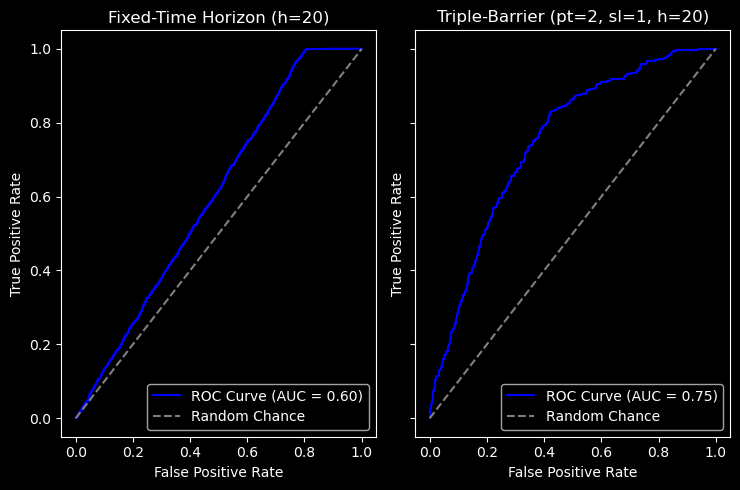

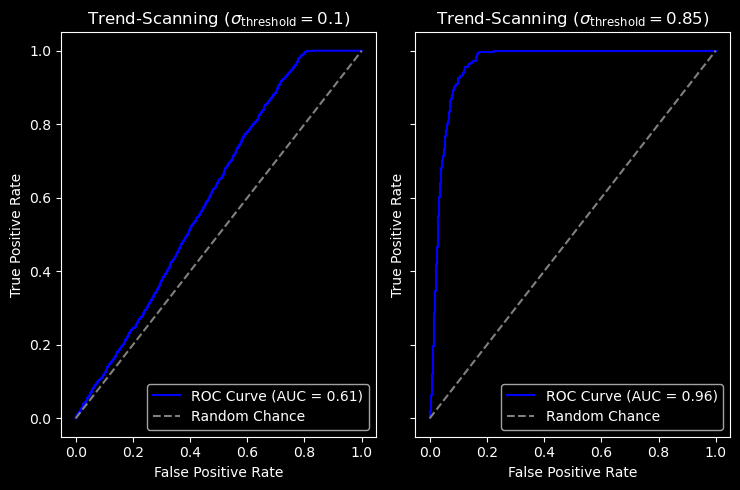

In [ ]:
bb_models = [model_bb_fh_tick, model_bb_tbl_tick, model_bb_trend_tick, model_bb_trend_mr_tick]
fp = Path(dirpath, "unweighted") 
fp.mkdir(parents=True, exist_ok=True)

bb_roc = compare_roc_curves(bb_models[:2], plot_titles[:2], columns=2)
bb_roc.savefig(dirpath / "bb_roc_barrier_comparison.png")

bb_roc_trend = compare_roc_curves(bb_models[2:], plot_titles[2:], columns=2)
bb_roc_trend.savefig(dirpath / "bb_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=bb_models, titles=bb_titles, output_filenames=filenames, path=fp)

2025-09-03 01:38:02.379 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\return_weighted\bb_w20_std1.5_fixed_horizon_w_primary_clf_report.png'
2025-09-03 01:38:02.503 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\return_weighted\bb_w20_std1.5_fixed_horizon_w_meta_clf_report.png'
2025-09-03 01:38:02.618 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\return_weighted\bb_w20_std1.5_triple_barrier_w_primary_clf_report.png'
2025-09-03 01:38:02.736 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\return_weighted\bb_w20_std1.5_triple_barrier_w_meta_clf_report.png'
2025-09-03 01:38:02.857 | IN

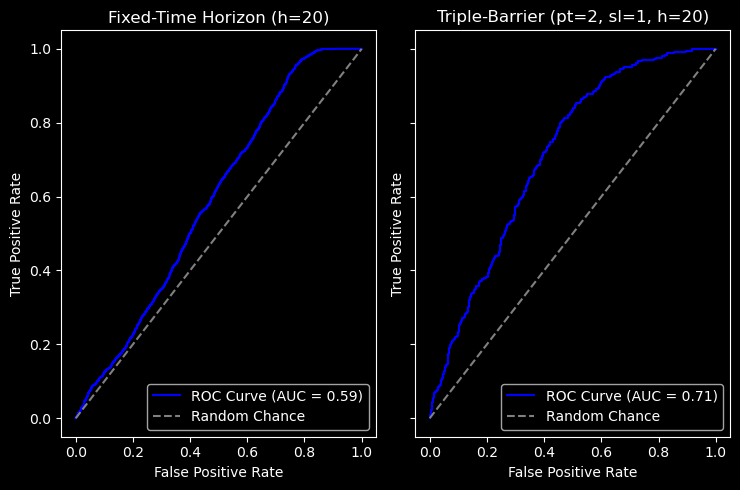

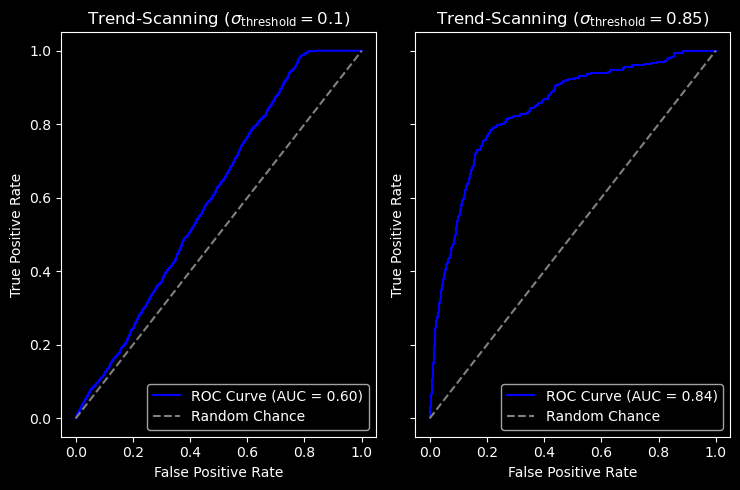

In [ ]:
fp_w = Path(dirpath, "return_weighted") 
bb_models_w = [model_bb_fh_tick_w, model_bb_tbl_tick_w, model_bb_trend_tick_w, model_bb_trend_mr_tick_w]
bb_titles_w = [f"Return-Weighted {w}" for w in bb_titles]
filenames_w = [f"{w}_w" for w in filenames]

bb_roc_w = compare_roc_curves(bb_models_w[:2], plot_titles[:2], columns=2)
bb_roc_w.savefig(dirpath / "bb_roc_barrier_comparison_w.png")

bb_roc_trend_w = compare_roc_curves(bb_models_w[2:], plot_titles[2:], columns=2)
bb_roc_trend_w.savefig(dirpath / "bb_roc_trend_comparison_w.png")

meta_labelling_classification_reports(model_data=bb_models_w, titles=bb_titles_w, output_filenames=filenames_w, path=fp_w)

In [ ]:
fp_tw = Path(dirpath, "time_weighted") 

plot_titles_tw = [fr"$\lambda = {decay}$" for decay in time_decays]
columns = 2
height = 7.5
fig_titles = [f"Time-Decay ($\lambda$): {method} ROC Curves" for method in bb_titles]

bb_models_tw, bb_titles_tw, filenames_tw = [], [], []
for time_decay, labels in models_bb_time_tw.items():
    for i, (label, model) in enumerate(labels.items()):
        bb_models_tw.append(model)
        bb_titles_tw.append(f"Time-Weighted (λ = {time_decay}) {bb_titles[i]}")
        filenames_tw.append(f"{filenames[i]}_tw_{time_decay}")

meta_labelling_classification_reports(model_data=bb_models_tw, titles=bb_titles_tw, output_filenames=filenames_tw, path=fp_tw)


2025-09-03 01:38:05.421 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\time_weighted\bb_w20_std1.5_fixed_horizon_tw_0.3_primary_clf_report.png'
2025-09-03 01:38:05.541 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\time_weighted\bb_w20_std1.5_fixed_horizon_tw_0.3_meta_clf_report.png'
2025-09-03 01:38:05.673 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\time_weighted\bb_w20_std1.5_triple_barrier_tw_0.3_primary_clf_report.png'
2025-09-03 01:38:05.806 | INFO     | afml.backtest_statistics.reporting:create_classification_report_image:433 - Successfully generated and saved 'reports\tick_bars\tick-200\time_weighted\bb_w20_std1.5_triple_barrier_tw_0.3_meta_clf_report.png'
2025-09-03 01:38

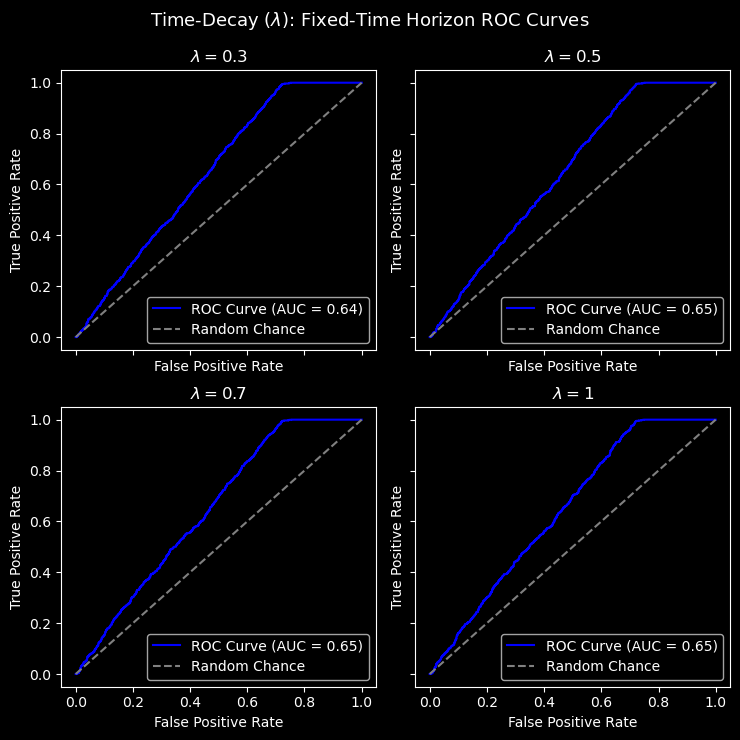

In [ ]:
fig_title = fig_titles[0]
bb_roc_fh_tw = compare_roc_curves(bb_models_tw[::4], plot_titles_tw, fig_title, columns, height)
bb_roc_fh_tw.savefig(dirpath / "bb_roc_fixed_horizon_comparison_time_weighted.png")


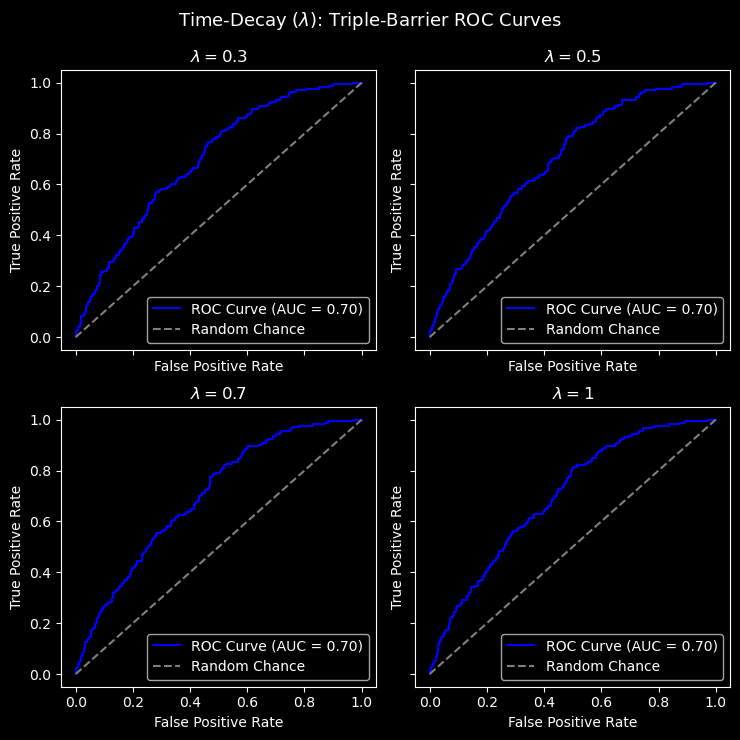

In [ ]:
fig_title = fig_titles[1]
bb_roc_tbl_tw = compare_roc_curves(bb_models_tw[1::4], plot_titles_tw, fig_title, columns, height)
bb_roc_tbl_tw.savefig(dirpath / "bb_roc_barrier_comparison_time_weighted.png")

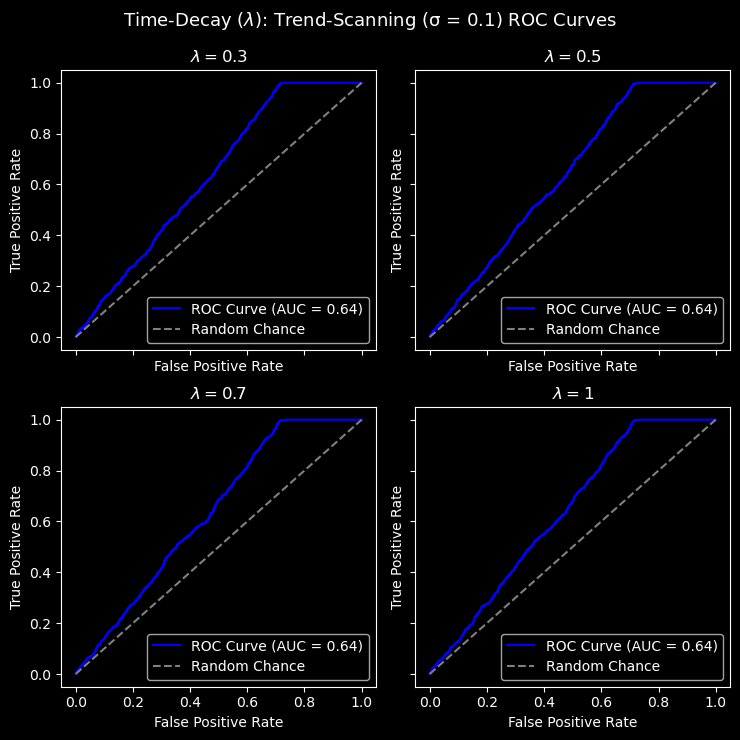

In [ ]:
fig_title = fig_titles[2]
bb_roc_trend_tw = compare_roc_curves(bb_models_tw[2::4], plot_titles_tw, fig_title, columns, height)
bb_roc_trend_tw.savefig(dirpath / f"bb_roc_trend_{volatility_threshold}_comparison_time_weighted.png")


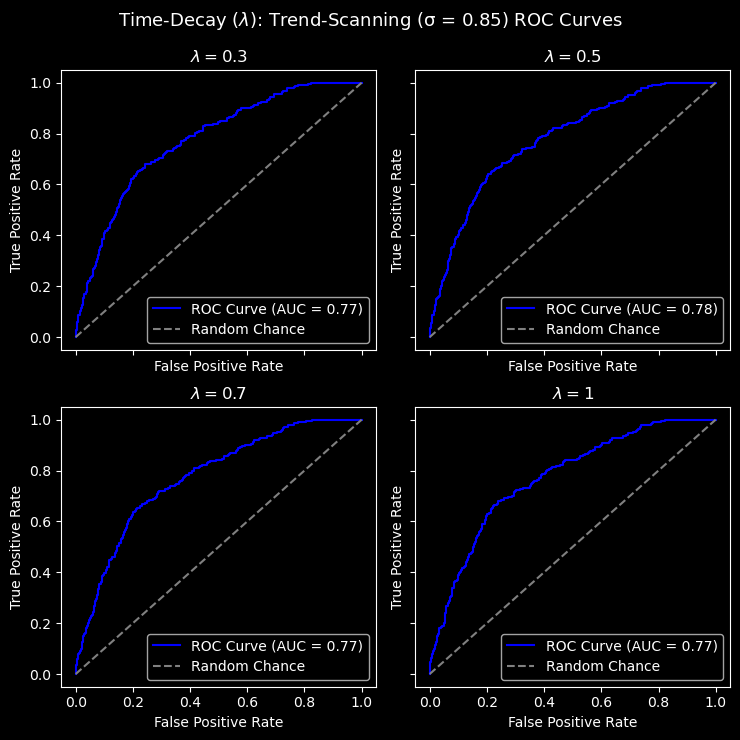

In [ ]:
fig_title = fig_titles[3]
bb_roc_trend_mr_tw = compare_roc_curves(bb_models_tw[3::4], plot_titles_tw, fig_title, columns, height)
bb_roc_trend_mr_tw.savefig(dirpath / f"bb_roc_trend_{volatility_threshold_mr}_comparison_time_weighted.png")

## 3. Moving Average Crossover Strategy

In [ ]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

ma_timeframe = "M30"
tick_bar_size = tick_bar_dict.get(ma_timeframe)
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
ma_bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"

fast_window, slow_window = 20, 50
ma_strategy = MovingAverageCrossoverStrategy(fast_window, slow_window)
ma_pt_barrier, ma_sl_barrier, ma_time_horizon = (4, 1.5, 100)
ma_vol_multiplier = 0.3
time_decay = 0.3
linear_decay = False

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq


### Time-Bars

In [ ]:
ma_df = ma_time_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=fast_window).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

ma_side = ma_strategy.generate_signals(ma_df)
vertical_barriers = add_vertical_barrier(t_events, close, num_bars=ma_time_horizon)

CUSUM filter threshold: 0.0478%, t_events: 18,373


#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_time = ma_feat.copy()
ma_feat.info()

Reloading 'afml.strategies.ma_crossover_feature_engine'.
Memory usage reduced from 27.33 MB to 13.74 MB (49.7% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  int8   
 6   ma_20_50_cross                  49280 non-null  int8   
 7   ma_50_200_cross                 49280 non-null  int8   
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 1

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_time = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_time = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

close = ma_df.close
vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_time = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_time = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Tick-Bars

In [ ]:
ma_df = ma_tick_bars.loc[sample_start : sample_end]
close = ma_df.close
vol_target = get_daily_vol(close, lookback=100) # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")
ma_side = ma_strategy.generate_signals(ma_df)

# Create vertical barriers
# Ensure time horizon aligns with that of time-bars
tm = int("".join(x for x in list(ma_timeframe) if x.isnumeric()))
ma_tick_horizon = ma_time_horizon * tm
if ma_timeframe.startswith("H"):
    ma_tick_horizon *= 60
elif ma_timeframe.startswith("D"):
    ma_tick_horizon *= 60 * 24

print(f"Time Horizon: {pd.Timedelta(minutes=tm)}")
vertical_barriers = add_vertical_barrier(t_events, close, minutes=ma_tick_horizon)

#### Feature Engineering

In [ ]:
ma_feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = ma_feat_engine.calculate_all_features(ma_df)
ma_feat_tick = ma_feat.copy()
ma_feat.info()

Reloading 'afml.strategies.ma_crossover_feature_engine'.
Memory usage reduced from 27.33 MB to 13.74 MB (49.7% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 85 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  int8   
 6   ma_20_50_cross                  49280 non-null  int8   
 7   ma_50_200_cross                 49280 non-null  int8   
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 1

#### Fixed-Time Horizon Method

In [ ]:
ma_events_fh = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[0,0],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_fh = get_event_weights(ma_events_fh, close)
ma_events_fh_tick = ma_events_fh.copy()
ma_events_fh.info()
ret = ma_events_fh.ret
sr_ma_fh = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_fh:.4f}")

#### Triple-Barrier Method

In [ ]:
ma_events_tbl = triple_barrier_labels(
    close=close,
    target=vol_target,
    t_events=t_events,
    pt_sl=[ma_pt_barrier, ma_sl_barrier],
    min_ret=0,
    vertical_barrier_times=vertical_barriers,
    side_prediction=ma_side,
    vertical_barrier_zero=True,
    verbose=False,
)
ma_events_tbl = get_event_weights(ma_events_tbl, close)
ma_events_tbl_tick = ma_events_tbl.copy()
ma_events_tbl.info()
ret = ma_events_tbl.ret
sr_ma_tbl = ret.mean() / ret.std()
print(f"\nSharpe Ratio: {sr_ma_tbl:.4f}")

In [ ]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    })
ma_metrics_df

#### Trend-Scanning Method

In [ ]:
span = (5, ma_time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

vol_target = get_daily_vol(close, lookback=100).dropna() # Volatility target for barriers
thres = vol_target.mean() * ma_vol_multiplier
t_events = cusum_filter(close, thres)
print(f"CUSUM filter threshold: {thres:.4%}, t_events: {t_events.size:,}")

side = ma_strategy.generate_signals(ma_df)

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_tick = ma_events_trend.copy()
ret = ma_events_trend.ret
sr_ma_trend = ret.mean() / ret.std()

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_mr_tick = ma_events_trend_mr.copy()
ret = ma_events_trend.ret_mr
sr_ma_trend_mr = ret.mean() / ret.std()

# ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

ma_metrics_df = pd.Series({
    "fixed_horizon": sr_ma_fh,
    "triple_barrier": sr_ma_tbl,
    "trend_scanning": sr_ma_trend,
    "trend_scanning_mr": sr_ma_trend_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

### Random Forest

In [ ]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )
time_decay = 0.3

##### Time-Bars

In [ ]:
model_ma_fh_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_fh_time)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(
    model_ma_fh_time.y_test, model_ma_fh_time.w_test, model_ma_fh_time.pred, model_ma_fh_time.prob, plot_roc=False
    )

In [ ]:
model_ma_tbl_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_tbl_time)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(
    model_ma_tbl_time.y_test, model_ma_tbl_time.w_test, model_ma_tbl_time.pred, model_ma_tbl_time.prob, plot_roc=False
    )

In [ ]:
model_ma_trend_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(
    model_ma_trend_time.y_test, model_ma_trend_time.w_test, model_ma_trend_time.pred, model_ma_trend_time.prob, plot_roc=False
    )

In [ ]:
model_ma_trend_mr_time = train_meta_model(model=rf, features=ma_feat_time, labels=ma_events_trend_mr_time)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(
    model_ma_trend_mr_time.y_test, model_ma_trend_mr_time.w_test, model_ma_trend_mr_time.pred, model_ma_trend_mr_time.prob, plot_roc=False
    )

###### Return-Weighted

2025-09-02 00:08:02.453 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1640
           1       0.00      0.00      0.00      1269

    accuracy                           0.56      2909
   macro avg       0.28      0.50      0.36      2909
weighted avg       0.32      0.56      0.41      2909


Confusion Matrix:
[[1640    0]
 [1269    0]]


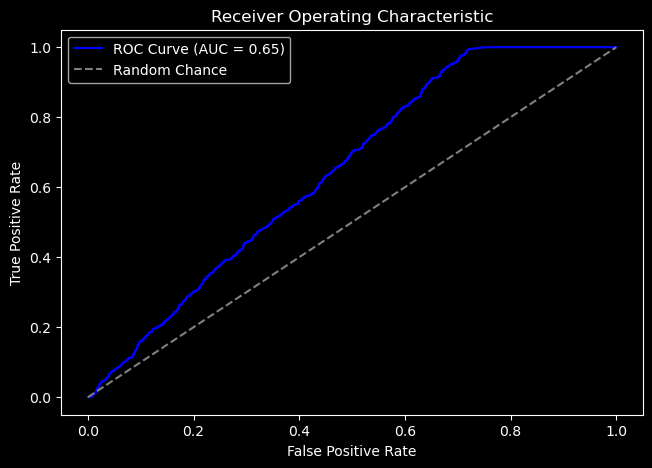

In [ ]:
model_bb_fh_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_fh_time, sample_weights=True)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_time_w, plot_roc=False)

2025-09-02 00:08:23.734 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Triple Barrier Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      2736
           1       0.09      0.74      0.16       173

    accuracy                           0.54      2909
   macro avg       0.53      0.64      0.42      2909
weighted avg       0.92      0.54      0.65      2909


Confusion Matrix:
[[1451 1285]
 [  45  128]]


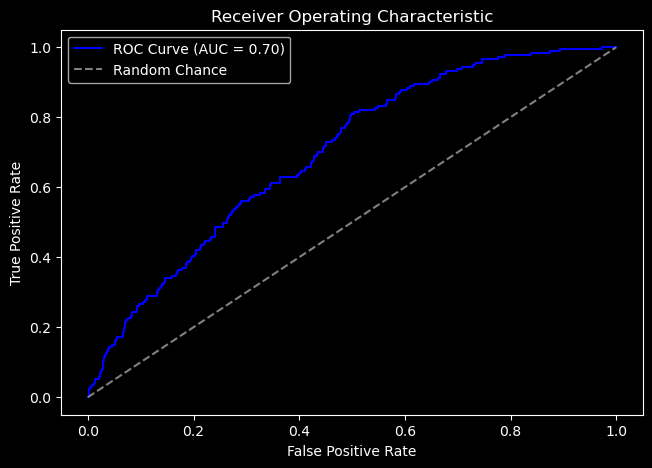

In [ ]:
model_bb_tbl_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_tbl_time, sample_weights=True)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_time_w, plot_roc=False)

Samples weighted by t-value.
2025-09-02 00:08:45.739 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.90      0.31      0.46      1572
           1       0.54      0.96      0.69      1337

    accuracy                           0.61      2909
   macro avg       0.72      0.63      0.57      2909
weighted avg       0.73      0.61      0.56      2909


Confusion Matrix:
[[ 481 1091]
 [  56 1281]]


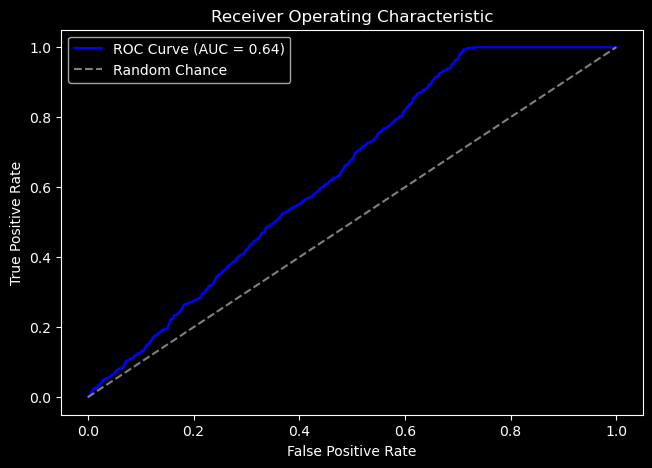

In [ ]:
model_bb_trend_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_time, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_time_w, plot_roc=False)

Reloading 'notebooks.training'.
Samples weighted by t-value.
2025-09-02 00:09:10.821 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      2688
           1       0.09      1.00      0.16       221

    accuracy                           0.22      2909
   macro avg       0.54      0.58      0.21      2909
weighted avg       0.93      0.22      0.26      2909


Confusion Matrix:
[[ 408 2280]


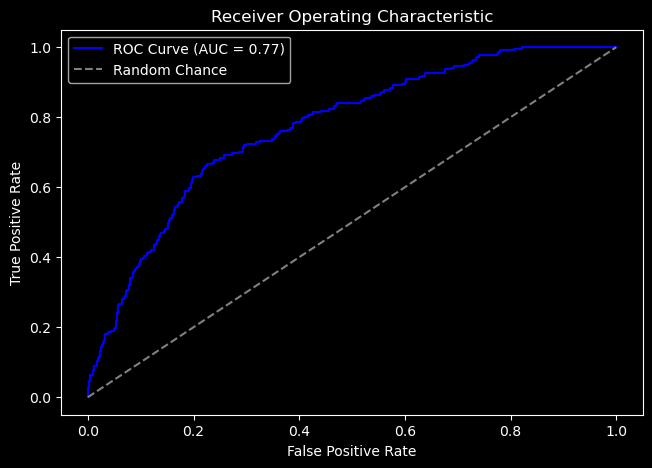

In [ ]:
model_bb_trend_mr_time_w = train_meta_model(model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, sample_weights=True)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_time_w, plot_roc=False)

###### Time-Decay Weighted

In [ ]:
model_bb_fh_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_fh_time, 
    sample_weights=True, weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_fh_time_tw, plot_roc=False)

------------------------------------------------------------
Fixed-Time Horizon Evaluation Report:
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1640
           1       0.44      1.00      0.61      1269

    accuracy                           0.44      2909
   macro avg       0.22      0.50      0.30      2909
weighted avg       0.19      0.44      0.26      2909


Confusion Matrix:
[[   0 1640]
 [   0 1269]]

META-MODEL PERFORMANCE:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.32      0.47      1640
           1       0.51      0.94      0.66      1269

    accuracy                           0.59      2909
   macro avg       0.69      0.63      0.56      2909
weighted avg       0

2025-09-02 00:16:18.524 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,788 samples...
Triple Barrier Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2736
           1       0.06      1.00      0.11       173

    accuracy                           0.06      2909
   macro avg       0.03      0.50      0.06      2909
weighted avg       0.00      0.06      0.01      2909


Confusion Matrix:
[[   0 2736]
 [   0  173]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      2736
           1       0.13      0.71      0.21       173

    accuracy                           0.69      2909
   macro avg       0.55      0.70      0.51      2909
weighted avg       0.92      0.69      0.77      2909


Confusion Matrix:
[[1894  842]
 [  51  122]]


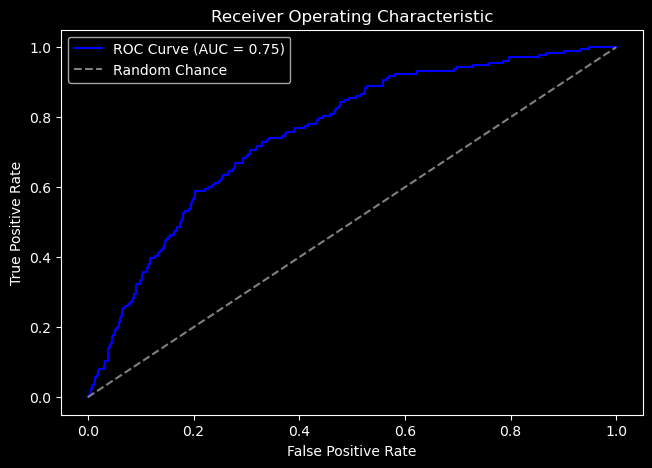

In [ ]:
model_bb_tbl_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_tbl_time, 
    sample_weights=True, weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_tbl_time_tw, plot_roc=False)

2025-09-02 00:16:40.212 | INFO     | notebooks.training:train_meta_model:91 - Training on 6,789 samples...
Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.32      0.47      1572
           1       0.54      0.93      0.68      1337

    accuracy                           0.60      2909
   macro avg       0.69      0.63      0.57      2909
weighted avg       0.71      0.60      0.57      2909


Confusion Matrix:
[[ 506 1066]
 [  91 1246]]


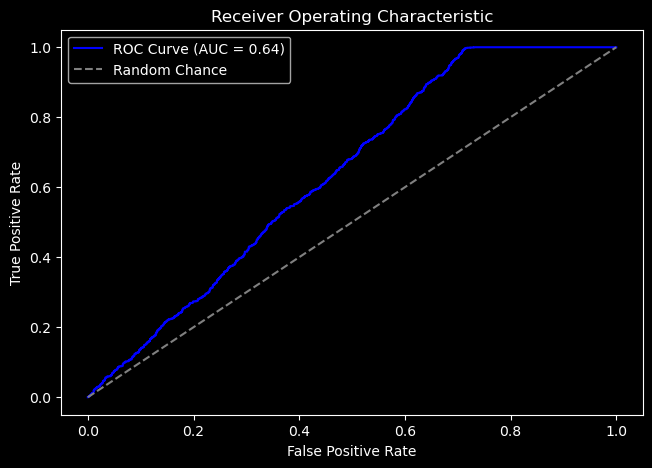

In [ ]:
model_bb_trend_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_time, 
    sample_weights=True, weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_time_tw, plot_roc=False)

In [ ]:
model_bb_trend_mr_time_tw = train_meta_model(
    model=rf, features=bb_feat_time, labels=bb_events_trend_mr_time, 
    sample_weights=True, weighting="time", time_decay=time_decay
    )
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold_mr}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_bb_trend_mr_time_tw, plot_roc=False)

------------------------------------------------------------
TREND-SCANNING (MEAN-REVERSION) EVALUATION REPORT:
------------------------------------------------------------

PRIMARY MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

META-MODEL PERFORMANCE:
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2688
           1       0.46      0.93      0.61       221

    accuracy                           0.91      2909
   macro avg       0.73      0.92      0.78      2909
weighted avg       0.

Reports

In [ ]:
dirpath = Path("reports", "time_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_time_horizon})", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_time, model_ma_tbl_time, model_ma_trend_time, model_ma_trend_mr_time]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=model_ma_fh_time, title="Fixed-Time Horizon", output_filename=dirpath / "ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl_time, title="Triple Barrier", output_filename=dirpath / "ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend_time, title=f"Trend-Scanning (σ = {volatility_threshold})", 
                                      output_filename=dirpath / "ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_mr_time, title=f"Trend-Scanning (σ = {volatility_threshold_mr})", 
                                      output_filename=dirpath / "ma_trend_scanning_mr")

##### Tick-Bars

In [ ]:
model_ma_fh_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_fh_tick)
print(f"{dashes}\nFIXED-TIME HORIZON EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_ma_fh_tick, plot_roc=False)

In [ ]:
model_ma_tbl_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_tbl_tick)
print(f"{dashes}\nTRIPLE-BARRIER EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_ma_tbl_tick, plot_roc=False)

In [ ]:
model_ma_trend_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_ma_trend_tick, plot_roc=False)

In [ ]:
model_ma_trend_mr_tick = train_meta_model(model=rf, features=ma_feat_tick, labels=ma_events_trend_mr_tick)
print(f"{dashes}\nTREND-SCANNING (σ = {volatility_threshold}) EVALUATION REPORT\n{dashes}")
meta_labelling_reports(model_ma_trend_mr_tick, plot_roc=False)

In [ ]:
dirpath = Path("reports", "tick_bars", ma_timeframe)
dirpath.mkdir(parents=True, exist_ok=True)

titles = [
    f"Fixed-Time Horizon (h={ma_tick_horizon} minutes)", 
    f"Triple Barrier (pt={ma_pt_barrier}, sl={ma_sl_barrier}, h={ma_tick_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh_tick, model_ma_tbl_tick, model_ma_trend_tick, model_ma_trend_mr_tick]
ma_roc = compare_roc_curves(ma_models[:2], plot_titles[:2])
ma_roc.savefig(dirpath / "ma_roc_barrier_comparison.png")

ma_roc_trend = compare_roc_curves(ma_models[2:], titles[2:])
ma_roc_trend.savefig(dirpath / "ma_roc_trend_comparison.png")

meta_labelling_classification_reports(model_data=ma_models, title=bb_titles, output_filename=dirpath / "ma_fixed_tick")